In [11]:
import warnings
warnings.filterwarnings('ignore')

In [12]:
from sklearn.cross_validation import train_test_split
from sklearn.metrics import log_loss
from sklearn import preprocessing
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import math

from hyperopt import hp
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
import sys
import xgboost as xgb
import datetime
import time
import operator

In [13]:
train = pd.read_csv('train.csv', parse_dates=['timestamp'])
test = pd.read_csv('test.csv', parse_dates=['timestamp'])
# macro = pd.read_csv('macro.csv', parse_dates=['timestamp'])
ids = test.id

In [14]:
# Add month-year
month_year = (train.timestamp.dt.month + train.timestamp.dt.year * 100)
month_year_cnt_map = month_year.value_counts().to_dict()
train['month_year_cnt'] = month_year.map(month_year_cnt_map)

month_year = (test.timestamp.dt.month + test.timestamp.dt.year * 100)
month_year_cnt_map = month_year.value_counts().to_dict()
test['month_year_cnt'] = month_year.map(month_year_cnt_map)

# Add week-year count
week_year = (train.timestamp.dt.weekofyear + train.timestamp.dt.year * 100)
week_year_cnt_map = week_year.value_counts().to_dict()
train['week_year_cnt'] = week_year.map(week_year_cnt_map)

week_year = (test.timestamp.dt.weekofyear + test.timestamp.dt.year * 100)
week_year_cnt_map = week_year.value_counts().to_dict()
test['week_year_cnt'] = week_year.map(week_year_cnt_map)

# Add month and day-of-week
train['month'] = train.timestamp.dt.month
train['dow'] = train.timestamp.dt.dayofweek

test['month'] = test.timestamp.dt.month
test['dow'] = test.timestamp.dt.dayofweek

# Other feature engineering
train['rel_floor'] = train['floor'] / train['max_floor'].astype(float)
train['rel_kitch_sq'] = train['kitch_sq'] / train['full_sq'].astype(float)

test['rel_floor'] = test['floor'] / test['max_floor'].astype(float)
test['rel_kitch_sq'] = test['kitch_sq'] / test['full_sq'].astype(float)

train.apartment_name=train.sub_area + train['metro_km_avto'].astype(str)
test.apartment_name=test.sub_area + train['metro_km_avto'].astype(str)

In [15]:
price = train.price_doc.values
train = train.drop(['price_doc', 'id', 'timestamp'], axis=1)
for f in train.columns.tolist():
    if (train[f].dtype=='object') or (train[f].dtype=='datetime64[ns]'):
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(train[f].values) )
        train[f] = lbl.transform(list(train[f].values))

In [16]:
test = test.drop(['id','timestamp'], axis=1)
for f in test.columns.tolist():
    if (test[f].dtype=='object') or (test[f].dtype=='datetime64[ns]'):
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(test[f].values) )
        test[f] = lbl.transform(list(test[f].values))

In [17]:
def rmsle(preds, dtrain):
    labels = dtrain.get_label()
    assert len(preds) == len(labels)
    labels = labels.tolist()
    preds = preds.tolist()
    terms_to_sum = [(math.log(labels[i] + 1) - math.log(max(0, preds[i]) + 1)) ** 2.0 for i, pred in enumerate(labels)]
    return 'rmsle', (sum(terms_to_sum) * (1.0 / len(preds))) ** 0.5

In [18]:
def rmsle_score(preds, y_test):
    labels = y_test.tolist()
    preds = preds.tolist()
    terms_to_sum = [(math.log(labels[i] + 1) - math.log(max(0, preds[i]) + 1)) ** 2.0 for i, pred in enumerate(labels)]
    return (sum(terms_to_sum) * (1.0 / len(preds))) ** 0.5

In [19]:
def score(params):
    print ("Training with params : ")
    print (params)
    num_round = int(params['n_estimators'])
    del params['n_estimators']
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dvalid = xgb.DMatrix(X_test, label=y_test)
    # watchlist = [(dvalid, 'eval'), (dtrain, 'train')]
    model = xgb.train(params, dtrain, num_round)
    predictions = model.predict(dvalid)
    score =   rmsle_score(predictions, y_test) 
    print ("\tScore {0}\n\n".format(score))
    return {'loss': score, 'status': STATUS_OK}

In [20]:
def optimize(trials):
    space = {
             'n_estimators' : hp.quniform('n_estimators', 100, 1500, 1),
             'eta' : hp.quniform('eta', 0.025, 0.5, 0.025),
             'max_depth' : hp.choice('max_depth', np.arange(1, 13, dtype=int)),
             'min_child_weight' : hp.quniform('min_child_weight', 1, 6, 1), 
             'subsample' : hp.quniform('subsample', 0.5, 1, 0.05),
             'alpha' : hp.quniform('alpha', 0, 1, 0.05),
             'gamma' : hp.quniform('gamma', 0.5, 1, 0.05),
             'colsample_bytree' : hp.quniform('colsample_bytree', 0.5, 1, 0.05),
             'eval_metric': 'rmse',
             'objective': 'reg:linear',
             'nthread' : 6,
             'silent' : 1
             }

    best = fmin(score, space, algo=tpe.suggest, trials=trials, max_evals= 5)  # increase max_evals
    print (best)

In [21]:
X, y = train, price
print ("Splitting data into train and valid ...\n\n")
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=1234)
print (X_train.shape, X_test.shape, y_train.shape, y_test.shape )

Splitting data into train and valid ...


(24376, 295) (6095, 295) (24376,) (6095,)


In [22]:
#Trials object where the history of search will be stored
trials = Trials()

In [23]:
optimize(trials)

Training with params : 
{'objective': 'reg:linear', 'n_estimators': 1092.0, 'silent': 1, 'gamma': 0.6000000000000001, 'min_child_weight': 4.0, 'nthread': 6, 'max_depth': 12, 'eval_metric': 'rmse', 'subsample': 0.5, 'colsample_bytree': 0.55, 'eta': 0.125, 'alpha': 0.2}
	Score 0.5192495098073925


Training with params : 
{'objective': 'reg:linear', 'n_estimators': 1240.0, 'silent': 1, 'gamma': 0.65, 'min_child_weight': 3.0, 'nthread': 6, 'max_depth': 11, 'eval_metric': 'rmse', 'subsample': 0.75, 'colsample_bytree': 0.8500000000000001, 'eta': 0.05, 'alpha': 0.25}
	Score 0.4754281821883944


Training with params : 
{'objective': 'reg:linear', 'n_estimators': 893.0, 'silent': 1, 'gamma': 0.9500000000000001, 'min_child_weight': 3.0, 'nthread': 6, 'max_depth': 6, 'eval_metric': 'rmse', 'subsample': 0.8500000000000001, 'colsample_bytree': 0.5, 'eta': 0.1, 'alpha': 0.75}
	Score 0.5114699333518677


Training with params : 
{'objective': 'reg:linear', 'n_estimators': 1379.0, 'silent': 1, 'gamma':

In [1]:
# results = trials.best_trial['misc']['vals']
# results

In [24]:
params = {'objective': 'reg:linear',
          'booster': 'gbtree',
          'nthread': 4,
          'silent': 1,
          'alpha': 0.45,
          'gamma' : 0.5, 
          'min_child_weight': 5.0,
          'max_depth': 10,
          'subsample': 0.7000000000000001,
          "colsample_bytree": 0.9500000000000001,
          'eta': 0.025,
          'verbose_eval': True,
          'seed': 0}

In [25]:
dtrain = xgb.DMatrix(X, label= y )
dtest = xgb.DMatrix(test)

In [26]:
params

{'alpha': 0.45,
 'booster': 'gbtree',
 'colsample_bytree': 0.9500000000000001,
 'eta': 0.025,
 'gamma': 0.5,
 'max_depth': 10,
 'min_child_weight': 5.0,
 'nthread': 4,
 'objective': 'reg:linear',
 'seed': 0,
 'silent': 1,
 'subsample': 0.7000000000000001,
 'verbose_eval': True}

[0]	train-rmsle:3.66617	test-rmsle:3.67725
[50]	train-rmsle:0.475461	test-rmsle:0.529983
[100]	train-rmsle:0.380381	test-rmsle:0.463881
[150]	train-rmsle:0.366635	test-rmsle:0.465217


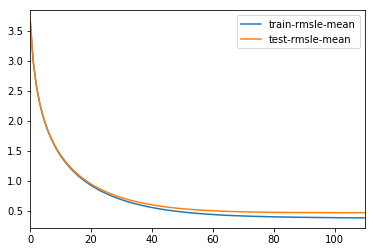

In [27]:
num_rounds = 1000
cv_output = xgb.cv(params, dtrain, num_boost_round=num_rounds, feval=rmsle, early_stopping_rounds=50, verbose_eval=50, show_stdv=False)
cv_output[['train-rmsle-mean', 'test-rmsle-mean']].plot()

In [29]:
num_rounds = len(cv_output)
watchlist = [(dtrain, 'dtrain')]
t1= time.time()
clf_xgb_main = xgb.train(dtrain=dtrain, params=params, feval= rmsle, num_boost_round=num_rounds, evals=watchlist, verbose_eval=20)
preds_price = clf_xgb_main.predict(dtest)
time.time() - t1

[0]	dtrain-rmsle:3.66156
[20]	dtrain-rmsle:0.922622
[40]	dtrain-rmsle:0.556628
[60]	dtrain-rmsle:0.443072
[80]	dtrain-rmsle:0.407084
[100]	dtrain-rmsle:0.395044


49.23134469985962

In [31]:
# preds_price = np.zeros(len(test))
# count = 1
# for s in np.random.randint(0, 1000000, size=50):
#     params['seed'] = s
#     t1= time.time()
#     clf_xgb_main = xgb.train(dtrain=dtrain, params=params, feval= rmsle, num_boost_round=num_rounds, \
#                              evals=watchlist,verbose_eval= 50)
#     preds_price += clf_xgb_main.predict(dtest)
#     print (count, time.time() - t1)
#     count = count +1
# preds_price = preds_price/50

In [32]:
def write_submission(preds, output):
    sample = pd.read_csv('sample_submission.csv')
    preds = pd.DataFrame(
        preds, index=sample.id.values, columns=sample.columns[1:])
    preds.to_csv(output, index_label='id')

In [33]:
test= pd.read_csv('test.csv')
submission = test[['id']] 
submission['price_doc'] = preds_price
submission.head()

,id,price_doc
0,30474,61809132.5
1,30475,94813480.5
2,30476,62717610.5
3,30477,66335019.0
4,30478,57737479.5


In [35]:
sub_file = 'sberbank.csv'
submission.to_csv(sub_file, index=False)

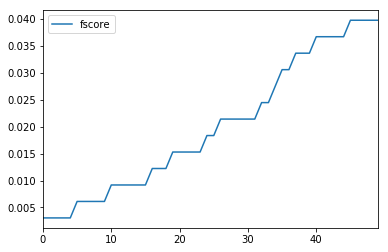

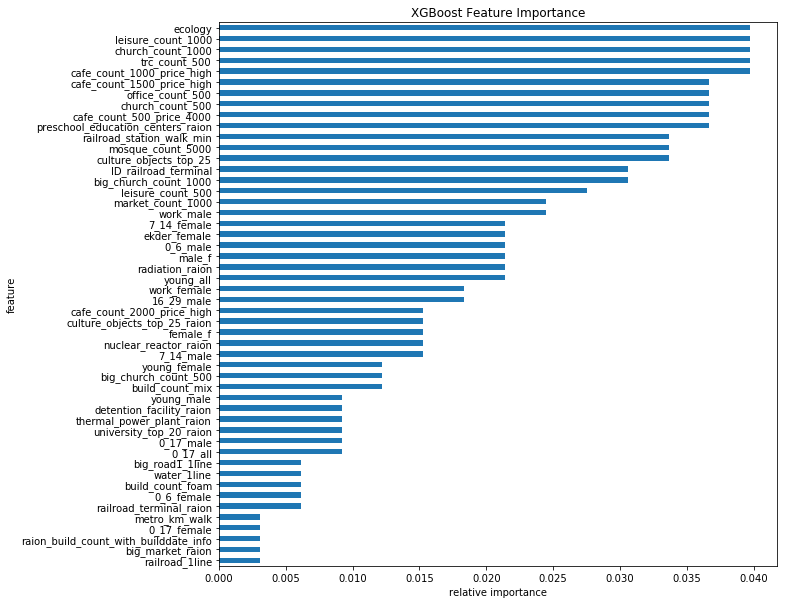

In [36]:
def create_feature_map(features):
    outfile = open('xgb.fmap', 'w')
    i = 0
    for feat in features:
        outfile.write('{0}\t{1}\tq\n'.format(i, feat))
        i = i + 1

    outfile.close()

create_feature_map(train.columns.values)

importance = clf_xgb_main.get_fscore(fmap='xgb.fmap')
importance = sorted(importance.items(), key=operator.itemgetter(1))

df = pd.DataFrame(importance[:50], columns=['feature', 'fscore'])
df['fscore'] = df['fscore'] / df['fscore'].sum()
 
plt.figure()
df.plot()
df.plot(kind='barh', x='feature', y='fscore', legend=False, figsize=(10, 10))
plt.title('XGBoost Feature Importance')
plt.xlabel('relative importance')
plt.gcf().savefig('feature_importance_xgb.png')